In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from pathlib import Path
import numpy as np
import copy

In [32]:
dir_github = Path(r'D:\RH_local\github').resolve()

dir_analysisFiles = Path(r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6\20210410_test\analysis_lastNight').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p = Path(r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6\20210410_test\exp\suite2p\plane0').resolve()



## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


## Directory of the Cascade repo
dir_cascade = dir_github / 'Cascade'

## Directory to save spks_cas into
dir_save = dir_analysisFiles

In [4]:
import sys
# sys.path.append('/n/groups/datta/akshay/bmi')
sys.path.append(str(dir_github))

# from Cascade import cascade2p.cascade2p
from Cascade.cascade2p import checks
checks.check_packages()
from Cascade.cascade2p import cascade # local folder
from Cascade.cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

# my libraries
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

	YAML reader installed (version 0.17.2).
	Keras installed (version 2.5.0).
	Tensorflow installed (version 2.5.0).


In [5]:
## == IMPORT DATA ==
F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
# iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

In [16]:
iscell = np.load(path_iscell)
dFoF_params = pickle_helpers.simple_load(path_tqm)['dFoF_params']

In [19]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

Calculated dFoF. Total elapsed time: 0.89 seconds
ThreadPool elapsed time : 0.29 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.7 seconds


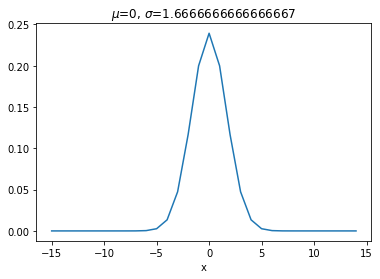

In [20]:
channelOffset_correction = dFoF_params['channelOffset_correction']
percentile_baseline      = dFoF_params['percentile_baseline']
neuropil_fraction        = dFoF_params['neuropil_fraction']

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(F=F_toUse + channelOffset_correction,
                                                                 Fneu=Fneu_toUse + channelOffset_correction,
                                                                 neuropil_fraction=neuropil_fraction,
                                                                 percentile_baseline=percentile_baseline,
                                                                 multicore_pref=True,
                                                                 verbose=True)

kernel_smoothing = math_functions.gaussian(np.arange(-(Fs)//2, (Fs)//2), 0, sig=50/Fs, plot_pref=True)[0]
dFoF_smooth = timeSeries.convolve_along_axis(dFoF,
                                             kernel=kernel_smoothing,
                                             axis=1,mode='same',
                                             multicore_pref=True,
                                             verbose=True).astype(np.float32)

Calculated dFoF. Total elapsed time: 0.89 seconds
ThreadPool elapsed time : 0.29 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.7 seconds


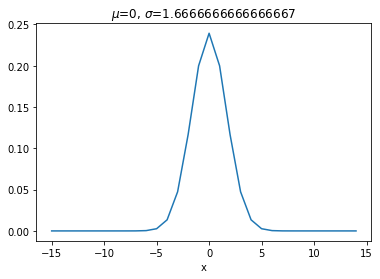

In [20]:
channelOffset_correction = dFoF_params['channelOffset_correction']
percentile_baseline      = dFoF_params['percentile_baseline']
neuropil_fraction        = dFoF_params['neuropil_fraction']

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(F=F,
                                                                 Fneu=Fneu,
                                                                 neuropil_fraction=0.7,
                                                                 percentile_baseline=10,
                                                                 multicore_pref=True,
                                                                 verbose=True)

kernel_smoothing = math_functions.gaussian(np.arange(-(Fs)//2, (Fs)//2), 0, sig=50/Fs, plot_pref=True)[0]
dFoF_smooth = timeSeries.convolve_along_axis(dFoF,
                                             kernel=kernel_smoothing,
                                             axis=1,mode='same',
                                             multicore_pref=True,
                                             verbose=True).astype(np.float32)

In [7]:
## Allow for downloading through SSL
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [22]:
def show_available_models(dir_cascade):
#     import ssl
#     ssl._create_default_https_context = ssl._create_unverified_context

    cascade.download_model('update_models', model_folder=dir_cascade, verbose = 1)

    yaml_file = open(dir_cascade / 'Pretrained_models/available_models.yaml')
    # yaml_file = open('Pretrained_models/available_models.yaml')
    X = yaml.load(yaml_file, Loader=yaml.Loader)
    list_of_models = list(X.keys())
    print('\n List of available models: \n')
    for model in list_of_models:
        print(model)

def download_model(model_name='Global_EXC_30Hz_smoothing50ms_causalkernel', dir_cascade='/', verbose=True):
    cascade.download_model( model_name, model_folder=dir_cascade, verbose = 1)

def predict(traces, dir_cascade='/', num_batches=1, empty_list_for_inplace_dataRecovery=[]):
    from tqdm import tqdm
    spike_probs = empty_list_for_inplace_dataRecovery
    with tqdm(total=num_batches) as pbar:
        for batch in indexing.make_batches(traces, num_batches=num_batches):
            spike_prob = cascade.predict(model_name=model_name,
                                                     traces=batch, 
                                                     model_folder=dir_cascade, 
                                                     padding=0)
            spike_probs.append(spike_prob)
            pbar.update(1)

    spks_cas = np.concatenate(spike_probs, axis=0).astype(np.float32)
    return spks_cas

In [23]:
model_name = 'Global_EXC_30Hz_smoothing50ms_causalkernel'

download_model( model_name, dir_cascade=dir_cascade, verbose=True)

Pretrained model was saved in folder "D:\RH_local\github\Cascade\Global_EXC_30Hz_smoothing50ms_causalkernel"


In [30]:
traces_toUse = dFoF_smooth
batch_size = 100

num_batches = np.ceil(traces_toUse.shape[0]/batch_size).astype(np.int64)
fallback = []
spks_cas = predict(
    traces=traces_toUse,
    dir_cascade=dir_cascade,
    num_batches=num_batches,
    empty_list_for_inplace_dataRecovery=fallback
)

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 95 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.23, 0.04

Predictions for noise level 2:
	... ensemble 0
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 1
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 2
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 3
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 4
1253/1253 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions

  8%|██████▍                                                                            | 1/13 [00:38<07:39, 38.33s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 95 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.22, 0.04

Predictions for noise level 2:
	... ensemble 0
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 1
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 2
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 3
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 4
1253/1253 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions

 15%|████████████▊                                                                      | 2/13 [01:17<07:04, 38.56s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 95 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.2, 0.03

Predictions for noise level 2:
	... ensemble 0
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 1
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 2
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 3
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 4
1253/1253 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions 

 23%|███████████████████▏                                                               | 3/13 [01:55<06:26, 38.67s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 95 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.21, 0.04

Predictions for noise level 2:
	... ensemble 0
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 1
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 2
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 3
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 4
1253/1253 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions

 31%|█████████████████████████▌                                                         | 4/13 [02:34<05:48, 38.74s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 95 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.22, 0.04

Predictions for noise level 2:
	... ensemble 0
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 1
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 2
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 3
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 4
1253/1253 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions

 38%|███████████████████████████████▉                                                   | 5/13 [03:14<05:13, 39.23s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 95 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.22, 0.04

Predictions for noise level 2:
	... ensemble 0
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 1
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 2
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 3
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 4
1253/1253 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions

 46%|██████████████████████████████████████▎                                            | 6/13 [03:53<04:33, 39.11s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 95 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.21, 0.04

Predictions for noise level 2:
	... ensemble 0
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 1
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 2
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 3
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 4
1253/1253 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions

 54%|████████████████████████████████████████████▋                                      | 7/13 [04:32<03:53, 38.97s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 95 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.21, 0.04

Predictions for noise level 2:
	... ensemble 0
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 1
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 2
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 3
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 4
1253/1253 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions

 62%|███████████████████████████████████████████████████                                | 8/13 [05:11<03:14, 38.93s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 95 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.21, 0.04

Predictions for noise level 2:
	... ensemble 0
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 1
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 2
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 3
1253/1253 [==============================] - 6s 4ms/step
	... ensemble 4
1253/1253 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions

 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [05:49<02:35, 38.85s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 95 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.2, 0.04

Predictions for noise level 2:
	... ensemble 0
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 1
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 2
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 3
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 4
1253/1253 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions 

 77%|███████████████████████████████████████████████████████████████                   | 10/13 [06:28<01:56, 38.88s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 95 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.2, 0.05

Predictions for noise level 2:
	... ensemble 0
1253/1253 [==============================] - 8s 6ms/step
	... ensemble 1
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 2
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 3
1253/1253 [==============================] - 6s 4ms/step
	... ensemble 4
1253/1253 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions 

 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [07:10<01:19, 39.71s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 95 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.21, 0.06

Predictions for noise level 2:
	... ensemble 0
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 1
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 2
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 3
1253/1253 [==============================] - 5s 4ms/step
	... ensemble 4
1253/1253 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions

 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [07:49<00:39, 39.62s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 87 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.21, 0.05

Predictions for noise level 2:
	... ensemble 0
1147/1147 [==============================] - 5s 4ms/step
	... ensemble 1
1147/1147 [==============================] - 5s 4ms/step
	... ensemble 2
1147/1147 [==============================] - 5s 4ms/step
	... ensemble 3
1147/1147 [==============================] - 5s 4ms/step
	... ensemble 4
1147/1147 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [08:25<00:00, 38.92s/it]


In [31]:
np.save(dir_save / 'spks_cas.npy', np.single(spks_cas))

In [29]:
pickle_helpers.simple_save(
    obj={
        "iscell_spksCas": iscell,
        "dFoF_params": dFoF_params,
        "model_name": model_name,
    },
    filename= dir_save / 'spksCas_params.pkl'
)